# Demo Regression

In this notebook, we will look showcase how to implement a JAX trainer for research purposes. We will use the documentation from the [uvadlc notebooks](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide4/Research_Projects_with_JAX.html) and adapt this to the libraries I would like to use:
* serket
* optax

In [4]:
import pytorch_lightning
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])
nn_model = "/Users/eman/code_projects/eqx-nerf"

# append to path
sys.path.append(str(root))
sys.path.append(str(nn_model))

In [5]:
# Standard libraries
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict

# JAX/Flax
# If you run this code on Colab, remember to install flax and optax
# !pip install --quiet --upgrade flax optax
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
# from flax.training import train_state, checkpoints
import optax

# PyTorch for data loading
import torch
import torch.utils.data as data

# Logging with Tensorboard or Weights and Biases
# If you run this code on Colab, remember to install pytorch_lightning
# !pip install --quiet --upgrade pytorch_lightning
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_2968/3277314251.py:35: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [6]:
import equinox as eqx
from eqx_nerf import SirenNet

## Data

In [7]:
def target_function(x):
    return np.sin(x * 10.0)

class RegressionDataset(data.Dataset):

    def __init__(self, num_points, seed):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.x = rng.uniform(low=-1.0, high=1.0, size=num_points)
        self.y = target_function(self.x)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx:idx+1], self.y[idx:idx+1]

In [8]:
train_set = RegressionDataset(num_points=1000, seed=42)
val_set = RegressionDataset(num_points=200, seed=43)
test_set = RegressionDataset(num_points=500, seed=44)

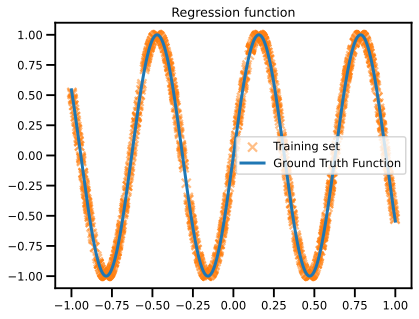

In [9]:

x = np.linspace(-1, 1, 1000)
plt.scatter(train_set.x, train_set.y, color='C1', marker='x', alpha=0.5, label='Training set')
plt.plot(x, target_function(x), linewidth=3.0, label='Ground Truth Function')
plt.legend()
plt.title('Regression function')
plt.show()

In [10]:
import jax
from torch.utils.data import DataLoader
from eqx_trainer import numpy_collate


class NumpyLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        num_workers=0,
        pin_memory=False,
        drop_last=False,
        timeout=0,
        worker_init_fn=None,
        collate_fn=numpy_collate,
        persistent_workers=False,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
        )

## DataModule

In [11]:
import pytorch_lightning as pl

class RegressionDataModule(pl.LightningDataModule):
    def __init__(
            self, num_train: int=1000, num_valid: int=200, num_test: int=500, seed=42,
            num_workers: int=0, batch_size: int=32):
        super().__init__()
        self.num_train = num_train
        self.num_valid = num_valid
        self.num_test = num_test
        self.seed = seed
        self.num_workers = num_workers
        self.batch_size = batch_size

    def setup(self, stage: str=None) -> None:
        self.train_set = RegressionDataset(num_points=self.num_train, seed=42)
        self.val_set = RegressionDataset(num_points=self.num_valid, seed=43)
        self.test_set = RegressionDataset(num_points=self.num_test, seed=44)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=self.train_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=self.val_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=False,
        )
    def test_dataloader(self):
        return data.DataLoader(
            dataset=self.test_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=False,
        )



In [12]:
dm = RegressionDataModule(num_train=1_000, num_valid=200, num_test=500,
                          batch_size=128)
dm.setup()

In [13]:
for ibatch in tqdm(dm.train_dataloader()):
    break

print(ibatch[0].shape, ibatch[1].shape, type(ibatch[0]))

  0%|          | 0/8 [00:00<?, ?it/s]

(128, 1) (128, 1) <class 'numpy.ndarray'>


## Model

In [86]:
import equinox as eqx
from equinox.nn.linear import Identity
from eqx_nerf import SirenNet
import jax.random as jrandom


model = SirenNet(
    in_size=1, out_size=1, width_size=128, depth=2,
    key=jrandom.PRNGKey(123)
)

# model = eqx.nn.composed.MLP(
#     in_size=1, out_size=1, 
#     width_size=128, depth=2, 
#     activation=eqx.nn.activations.PReLU(),
#     final_activation=Identity(),
#     key=jrandom.PRNGKey(123)
# )


# check output of models
out = jax.vmap(model)(ibatch[0])

assert out.shape == ibatch[0].shape
model

SirenNet(
  layers=(
    Siren(
      w0=30.0,
      c=6.0,
      weight=f32[128,1],
      bias=f32[128],
      in_features=1,
      out_features=128,
      use_bias=True,
      is_first=True,
      activation=Sine(w0=30.0)
    ),
    Siren(
      w0=1.0,
      c=6.0,
      weight=f32[128,128],
      bias=f32[128],
      in_features=128,
      out_features=128,
      use_bias=True,
      is_first=False,
      activation=Sine(w0=1.0)
    ),
    Siren(
      w0=1.0,
      c=6.0,
      weight=f32[1,128],
      bias=f32[1],
      in_features=128,
      out_features=1,
      use_bias=True,
      is_first=False,
      activation=Identity()
    )
  ),
  in_size=1,
  out_size=1,
  width_size=128,
  depth=2
)

## Optimizer (+ Learning Rate)

In [87]:
learning_rate = 4e-4
warmup_steps = 10
num_epochs = 500
num_steps_per_epoch = len(dm.train_dataloader())
eta = 0.01
start_lr = 0.0

# optimizer = optax.adamw(learning_rate=learning_rate)
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=start_lr,
    peak_value=learning_rate,
    warmup_steps=warmup_steps,
    decay_steps=int(num_epochs * num_steps_per_epoch),
    end_value=eta * learning_rate
)
clip = optax.clip_by_global_norm(1.0)
optimizer = optax.chain(
    clip,
    optax.adamw(lr_scheduler)
)
# optimizer.init(model)

In [88]:
type(optimizer)

optax._src.base.GradientTransformation

## Loggers

In [89]:
loggers = list()

log_dir = "./"
wandb_logger = WandbLogger(
    mode="disabled",
    save_dir=log_dir,
    entity="ige",
    project="jax4eo",
)

loggers.append(wandb_logger)

/Users/eman/miniconda3/envs/jax_eo_py310/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


## Trainer Module

In [90]:
from eqx_trainer._src.base import TrainerModule

class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 input_init,
                 **kwargs):
        super().__init__(model=model, optimizer=optimizer, input_init=input_init, **kwargs)

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, y = batch
            pred = jax.vmap(model)(x)
            loss = jnp.mean((y - pred)**2)
            return loss
            
        
        def train_step(model, opt_state, batch):
            
            loss, grads = mse_loss(model, batch)
            updates, opt_state = self.optimizer.update(grads, opt_state, params=model)
            model = eqx.apply_updates(model, updates)
            metrics = {"loss": loss}
            return model, opt_state, loss, metrics


        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            return {"loss": loss}

        return train_step, eval_step


In [91]:
seed = 123
debug = False
enable_progress_bar = False

trainer = RegressorTrainer(
    model, 
    optimizer, 
    input_init=ibatch[0], 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar
)


In [92]:
wandb_logger

In [93]:

# trainer.load_model("./checkpoint.ckpt")

In [94]:
eqx.__version__, optax.__version__

('0.10.1', '0.1.4')

In [95]:
%%time


metrics = trainer.train_model(dm, 500)

Epochs: 500 | Loss: 8.707e-07: 100%|██████████| 500/500 [00:09<00:00, 55.31it/s]

CPU times: user 9.51 s, sys: 663 ms, total: 10.2 s
Wall time: 9.04 s


In [96]:
metrics

{'train/loss': 8.70741871494829e-07, 'epoch_time': 0.015594959259033203}

In [97]:
trainer.save_model("checkpoint.ckpt")

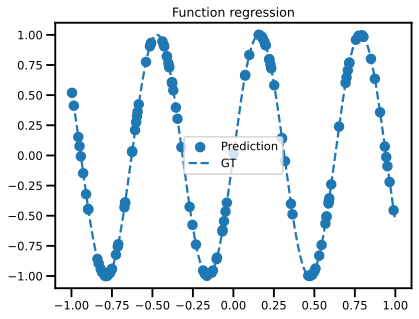

In [98]:
x = np.linspace(-1, 1, 1000)[:,None]
y_pred = jax.vmap(trainer.model)(ibatch[0])
plt.scatter(ibatch[0], y_pred, label='Prediction')
plt.plot(x, target_function(x), '--', label='GT')
plt.title('Function regression')
plt.legend()
plt.show()

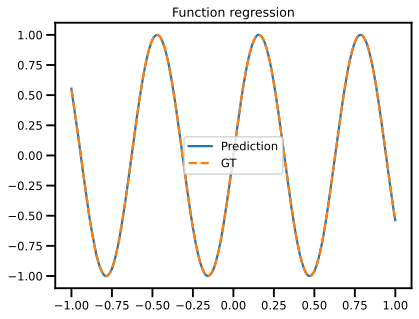

In [99]:
x = np.linspace(-1, 1, 1000)[:,None]
y_pred = jax.vmap(trainer.model)(x)
plt.plot(x, y_pred, label='Prediction')
plt.plot(x, target_function(x), '--', label='GT')
plt.title('Function regression')
plt.legend()
plt.show()

In [132]:
# !wget https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc

In [52]:
import xarray as xr
import pandas as pd

ds = xr.open_dataset(
    "NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc", decode_times=True)#.assign_coords(time=lambda ds: pd.to_datetime(ds.time))
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T12:00:00 ... 2013-09-30T12:00:00
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
Data variables:
    sst      (time, lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

In [41]:
from matplotlib import cm
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=-1.1, vmax=1.1)
cmap = cm.RdBu_r

m = cm.ScalarMappable(norm=norm, cmap=cmap)

(365, 201, 201)

In [72]:

class SineCosCycles:
    def __init__(self):
        pass

    def transform(self, x):
        data = x["time"]
        data = data.dt.day_of_year
        data = np.concatenate(
            [
                np.sin(data["doy"] / 360 * 2 * np.pi),
                np.cos(data["doy"] / 360 * 2 * np.pi)
            ]
        )
        x["time"] = data
        return x
class SSTDataset(data.Dataset):

    def __init__(self, time_slice, variable, seed):
        super().__init__()
        rng = np.random.default_rng(seed)
        ds = xr.open_dataset(
            "NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc", decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
        df = ds.isel(time=time_slice).to_dataframe().reset_index()
        df["doy"] = df["time"].dt.day_of_year
        df["sin_time"] = np.sin(df[["doy"]] /360 * 2 * np.pi)
        df["cos_time"] = np.cos(df[["doy"]] /360 * 2 * np.pi)
        self.x = {}
        self.x["spatial"] = df[["lat", "lon"]].values
        self.x["temporal"] = df[["lat", "lon"]].values
        self.y = df[[variable]].values

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx:idx+1], self.y[idx:idx+1]

In [73]:
sst_ds = SSTDataset(slice(60, 90), "sst", 123)
sst_ds[0]


(array([[ 3.30000000e+01, -6.50000000e+01,  1.74524064e-02,
          9.99847695e-01]]),
 array([[22.49443047]]))

In [49]:
class SSTDataModule(pl.LightningDataModule):
    def __init__(
            self, time_slice, variable, seed=42,
            num_workers: int=0, batch_size: int=1028):
        super().__init__()
        self.time_slice = time_slice
        self.variable = variable
        self.seed = seed
        self.num_workers = num_workers
        self.batch_size = batch_size

    def setup(self, stage: str=None) -> None:
        dataset = SSTDataset(time_slice=self.time_slice, variable=self.variable, seed=42)
        num_pts = len(dataset)
        num_train = np.ceil(0.8 * num_pts)
        num_valid = np.ceil(0.2 * num_pts)
        self.train_set, self.valid_set = torch.utils.data.random_split(dataset, lengths=[num_train, num_valid])

    def train_dataloader(self):
        return data.DataLoader(
            dataset=self.train_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=self.val_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=False,
        )
    # def test_dataloader(self):
    #     return data.DataLoader(
    #         dataset=self.test_set,
    #         batch_size=self.batch_size,
    #         collate_fn=numpy_collate,
    #         num_workers=self.num_workers,
    #         shuffle=False,
    #     )

In [54]:
dm = SSTDataModule(slice("2013-01-01", "2013-02-01"), "sst")
dm.setup()

TypeError: cannot perform __truediv__ with this index type: DatetimeArray

In [43]:
import math

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import optax  # https://github.com/deepmind/optax

import equinox as eqx

In [44]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size


def get_data(dataset_size, *, key):
    t = jnp.linspace(0, 2 * math.pi, 16)
    offset = jrandom.uniform(key, (dataset_size, 1), minval=0, maxval=2 * math.pi)
    x1 = jnp.sin(t + offset) / (1 + t)
    x2 = jnp.cos(t + offset) / (1 + t)
    y = jnp.ones((dataset_size, 1))

    half_dataset_size = dataset_size // 2
    x1 = x1.at[:half_dataset_size].multiply(-1)
    y = y.at[:half_dataset_size].set(0)
    x = jnp.stack([x1, x2], axis=-1)

    return x, y

In [45]:
class RNN(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear
    bias: jax.Array

    def __init__(self, in_size, out_size, hidden_size, *, key):
        ckey, lkey = jrandom.split(key)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey)
        self.bias = jnp.zeros(out_size)

    def __call__(self, input):
        hidden = jnp.zeros((self.hidden_size,))

        def f(carry, inp):
            return self.cell(inp, carry), None

        out, _ = lax.scan(f, hidden, input)
        # sigmoid because we're performing binary classification
        return jax.nn.sigmoid(self.linear(out) + self.bias)

In [46]:
dataset_size=10000
batch_size=32
learning_rate=3e-3
steps=200
hidden_size=16
depth=1
seed=5678

In [58]:
data_key, loader_key, model_key = jrandom.split(jrandom.PRNGKey(seed), 3)
xs, ys = get_data(dataset_size, key=data_key)
iter_data = dataloader((xs, ys), batch_size, key=loader_key)

model = RNN(in_size=2, out_size=1, hidden_size=hidden_size, key=model_key)

@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    # Trains with respect to binary cross-entropy
    loss = -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))
    return loss

# Important for efficiency whenever you use JAX: wrap everything into a single JIT
# region.
@eqx.filter_jit
def make_step(model, x, y, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [59]:
optim = optax.adam(learning_rate)
opt_state = optim.init(model)

In [60]:
x,y = next(iter_data)
loss, grads = compute_loss(model, x, y)

In [61]:
updates, opt_state = optim.update(grads, opt_state)